<a href="https://colab.research.google.com/github/AndreySmirdin/DeepUnsupervisedLearning/blob/hw3/Task6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import datetime
import pickle
import os
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal, Normal
import torchvision
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from tqdm.auto import tqdm
from google.colab import drive

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]

def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot([[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

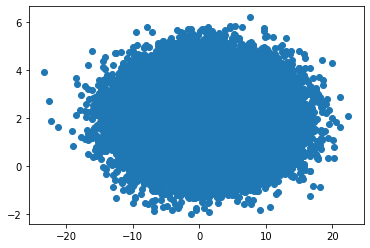

In [250]:
data_1 = sample_data_1()
data_2 = sample_data_2()
plt.scatter(data_1[:, 0], data_1[:, 1]);

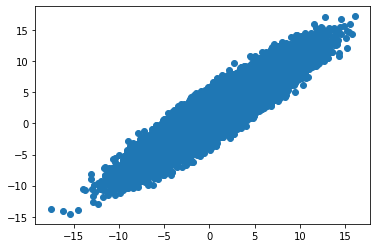

In [251]:
plt.scatter(data_2[:, 0], data_2[:, 1]);

In [0]:
class MLP(nn.Module):
    def __init__(self, in_size, out_size, hidden_size=256):
        super().__init__()
        self.hidden_size = hidden_size
        self.in_size = in_size
        self.out_size = out_size
        self.model = nn.Sequential(nn.Linear(self.in_size, self.hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(self.hidden_size, self.out_size))
        
    def forward(self, X):
        return self.model(X)

def get_kl_loss(mu, sigma):
    return (sigma.exp() + mu ** 2 - 1 - sigma) / 2

def get_decoder_loss(mu, sigma, x):
    return (torch.log(np.pi * 2 * sigma.exp())) / 2 + (x - mu) ** 2 / sigma.exp()

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def apply_normal(self, n, mu, sigma):
        return torch.randn(n, 2) * (sigma.exp() ** 0.5) + mu

    def forward(self, X):
        X = X.float()
        n = X.shape[0]
        sampled, mu_z, sigma_z = self.to_latent(X)
        decoded = self.decoder(sampled)
        mu_x, sigma_x = torch.chunk(decoded, 2, dim=1)

        kl_loss = get_kl_loss(mu_z, sigma_z)
        decoder_loss = get_decoder_loss(mu_x, sigma_x, X)
        return self.apply_normal(n, mu_x, sigma_x), decoder_loss.mean(), kl_loss.mean()

    def sample(self, n=1000):
        sampled = torch.randn((n, 2))
        mu, sigma = torch.chunk(self.decoder(sampled), 2, dim=1)
        print(mu.shape, sigma.shape)
        return mu, self.apply_normal(n, mu, sigma)

    def to_latent(self, X):
        X = X.float()
        n = X.shape[0]
        encoded = self.encoder(X)
        mu, sigma = torch.chunk(encoded, 2, dim=1)

        sampled = self.apply_normal(n, mu, sigma)
        return sampled, mu, sigma

In [0]:
def train(model, optim, train_loader, test_loader, num_epochs):
    losses, val_losses = [], []
    decoder_loss, kl_loss = [], []

    for epoch in tqdm(range(num_epochs)):
        loss, val_loss = 0, 0
        for batch in train_loader:
            batch = batch.to(device)
            optim.zero_grad()
            z, loss1, loss2 = model(batch)
            decoder_loss.append(loss1)
            kl_loss.append(loss2)
            cur_loss = loss1 + loss2
            loss += cur_loss.item()
            cur_loss.backward()
            optim.step()
        
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                z, loss1, loss2 = model(batch)
                cur_loss = loss1 + loss2
                val_loss += cur_loss.item()
                
        loss /= len(train_loader)
        val_loss /= len(test_loader)
        losses.append(loss)
        val_losses.append(val_loss)

        print(f'After epoch {epoch} train loss is {loss} valiidation loss is {val_loss}')
    kl_loss = kl_loss[50:]
    decoder_loss = decoder_loss[50:]
    plt.plot(np.arange(len(kl_loss)), kl_loss)
    plt.plot(np.arange(len(decoder_loss)), decoder_loss)
    plt.legend(('kl_loss', 'decoder_loss'));
    return losses, val_losses

def draw_losses(train_loss, val_loss):
    plt.plot(np.arange(len(val_loss)), val_loss)
    plt.plot(np.arange(len(loss)), loss)
    plt.legend(('validation','train'));

def draw_samples(model, data=None, n=1000):
    sample, sample_noise = model.sample(n)
    sample = sample.detach().numpy()
    sample_noise = sample_noise.detach().numpy()

    plt.scatter(sample_noise[:, 0], sample_noise[:, 1], color='blue')
    plt.scatter(sample[:, 0], sample[:, 1], color='yellow')
    plt.legend(('noise', 'mu only'));
    # if data is not None:
    #     plt.scatter(data[:n, 0], data[:n, 1], color='red');

batch_size = 1024

train_1, test_1 = train_test_split(data_1, train_size=0.8)
train_2, test_2 = train_test_split(data_2, train_size=0.8)
train_loader1 = torch.utils.data.DataLoader(train_1, batch_size=batch_size, shuffle=True)
test_loader1 = torch.utils.data.DataLoader(test_1, batch_size=batch_size, shuffle=False) 
train_loader2 = torch.utils.data.DataLoader(train_2, batch_size=batch_size, shuffle=True)
test_loader2 = torch.utils.data.DataLoader(test_2, batch_size=batch_size, shuffle=False) 

VAE 1, dataset 1


After epoch 0 train loss is 3.781243945978865 valiidation loss is 2.8232332348823546
After epoch 1 train loss is 2.7233579460578627 valiidation loss is 2.6815796732902526
After epoch 2 train loss is 2.6446654645702505 valiidation loss is 2.634673845767975
After epoch 3 train loss is 2.618038050736053 valiidation loss is 2.6145188927650453
After epoch 4 train loss is 2.6010198955294452 valiidation loss is 2.6064396858215333
After epoch 5 train loss is 2.593126212494283 valiidation loss is 2.595229184627533
After epoch 6 train loss is 2.584036250657673 valiidation loss is 2.5911325573921205
After epoch 7 train loss is 2.5803725387476666 valiidation loss is 2.582063102722168
After epoch 8 train loss is 2.5741339937041077 valiidation loss is 2.5820697426795958
After epoch 9 train loss is 2.57389332372931 valiidation loss is 2.5791407227516174



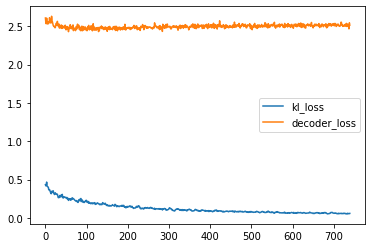

In [254]:
num_epochs = 10
encoder = MLP(2, 4)
decoder = MLP(2, 4)
model = VAE(encoder, decoder)
optim = torch.optim.Adam(model.parameters())
loss, val_loss = train(model, optim, train_loader1, test_loader1, num_epochs)

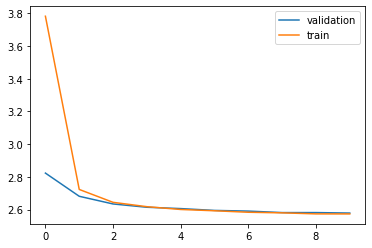

In [255]:
draw_losses(loss, val_loss)

torch.Size([1000, 2]) torch.Size([1000, 2])


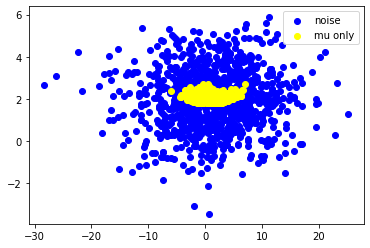

In [256]:
draw_samples(model, data_1)

VAE 1, dataset 2


After epoch 0 train loss is 4.7887669424467445 valiidation loss is 3.113174521923065
After epoch 1 train loss is 2.9792790020568463 valiidation loss is 2.857843506336212
After epoch 2 train loss is 2.789986375011975 valiidation loss is 2.710242211818695
After epoch 3 train loss is 2.6725035256977323 valiidation loss is 2.6253442049026487
After epoch 4 train loss is 2.610932217368597 valiidation loss is 2.5882036805152895
After epoch 5 train loss is 2.5895426182807246 valiidation loss is 2.5819900393486024
After epoch 6 train loss is 2.579782289794729 valiidation loss is 2.5705236554145814
After epoch 7 train loss is 2.57771833335297 valiidation loss is 2.5681933760643005
After epoch 8 train loss is 2.5749310239960876 valiidation loss is 2.577177846431732
After epoch 9 train loss is 2.578515282160119 valiidation loss is 2.569108748435974
After epoch 10 train loss is 2.577676175515863 valiidation loss is 2.5783229947090147
After epoch 11 train loss is 2.579133794277529 valiidation loss i

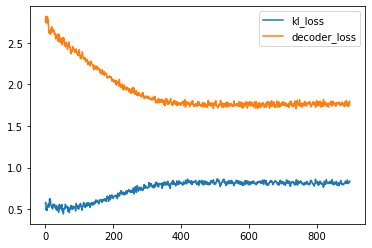

In [257]:
num_epochs = 12
encoder = Encoder(2, 4)
decoder = Decoder(2, 4)
model2 = VAE(encoder, decoder)
optim = torch.optim.Adam(model2.parameters())
loss, val_loss = train(model2, optim, train_loader2, test_loader2, num_epochs)

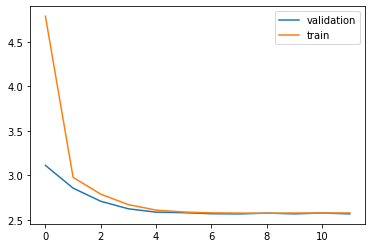

In [258]:
draw_losses(loss, val_loss)

torch.Size([1000, 2]) torch.Size([1000, 2])


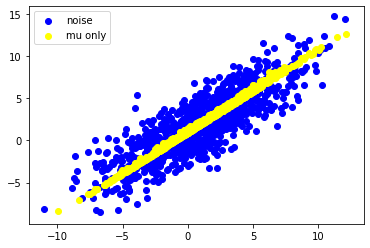

In [259]:
draw_samples(model2, data_2)

In [0]:
class VAE2(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def apply_normal(self, n, mu, sigma):
        return torch.randn(n, 2) * (sigma.exp() ** 0.5) + mu

    def split(self, x):
        mu = x[:, :-1]
        sigma = x[:, -1]
        return mu, sigma.reshape(-1, 1)

    def forward(self, X):
        X = X.float()
        n = X.shape[0]
        sampled, mu_z, sigma_z = self.to_latent(X)
        decoded = self.decoder(sampled)
        mu_x, sigma_x = self.split(decoded)

        kl_loss = get_kl_loss(mu_z, sigma_z)
        decoder_loss = get_decoder_loss(mu_x, sigma_x, X)
        return self.apply_normal(n, mu_x, sigma_x), decoder_loss.mean(), kl_loss.mean()

    def sample(self, n=1000):
        sampled = torch.randn((n, 2))
        decoded = self.decoder(sampled)
        mu, sigma = self.split(decoded)
        return mu, self.apply_normal(n, mu, sigma)

    def to_latent(self, X):
        X = X.float()
        n = X.shape[0]
        encoded = self.encoder(X)
        mu, sigma = self.split(encoded)

        sampled = self.apply_normal(n, mu, sigma)
        return sampled, mu, sigma

VAE 2, dataset 1

After epoch 0 train loss is 4.422556997854499 valiidation loss is 3.3633413553237914
After epoch 1 train loss is 3.1755001424234126 valiidation loss is 3.034464085102081
After epoch 2 train loss is 2.9576006237464614 valiidation loss is 2.918275260925293
After epoch 3 train loss is 2.892979769767085 valiidation loss is 2.8779934883117675
After epoch 4 train loss is 2.8578680346283734 valiidation loss is 2.8595161914825438
After epoch 5 train loss is 2.846989411341993 valiidation loss is 2.838840365409851
After epoch 6 train loss is 2.835634430752525 valiidation loss is 2.833953928947449
After epoch 7 train loss is 2.8335282410247418 valiidation loss is 2.8297170758247376
After epoch 8 train loss is 2.822371881219405 valiidation loss is 2.8389904618263246
After epoch 9 train loss is 2.8164607361902165 valiidation loss is 2.828790748119354



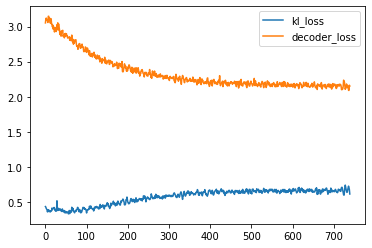

In [261]:
num_epochs = 10
encoder = Encoder(2, 3)
decoder = Decoder(2, 3)
model3 = VAE2(encoder, decoder)
optim = torch.optim.Adam(model3.parameters())
loss, val_loss = train(model3, optim, train_loader1, test_loader1, num_epochs)

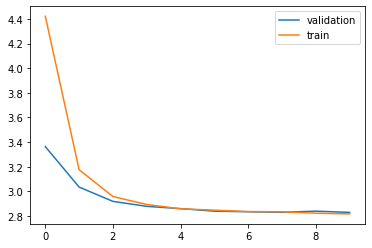

In [262]:
draw_losses(loss, val_loss)

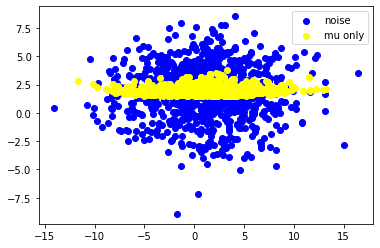

In [263]:
draw_samples(model3, data_1)

VAE 2, dataset 2


After epoch 0 train loss is 4.382728809042822 valiidation loss is 3.3413308024406434
After epoch 1 train loss is 3.1929500102996826 valiidation loss is 3.0536686897277834
After epoch 2 train loss is 2.9829996597917776 valiidation loss is 2.924612557888031
After epoch 3 train loss is 2.903863795195954 valiidation loss is 2.878348243236542
After epoch 4 train loss is 2.875863192956659 valiidation loss is 2.8625499606132507
After epoch 5 train loss is 2.8613330050359798 valiidation loss is 2.8532575607299804
After epoch 6 train loss is 2.8417825246159034 valiidation loss is 2.834855556488037
After epoch 7 train loss is 2.8330910990509808 valiidation loss is 2.825254487991333
After epoch 8 train loss is 2.82323728935628 valiidation loss is 2.8019924759864807
After epoch 9 train loss is 2.812577766708181 valiidation loss is 2.8071764945983886



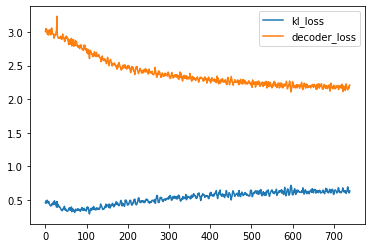

In [264]:
num_epochs = 10
encoder = Encoder(2, 3)
decoder = Decoder(2, 3)
model4 = VAE2(encoder, decoder)
optim = torch.optim.Adam(model4.parameters())
loss, val_loss = train(model4, optim, train_loader2, test_loader2, num_epochs)

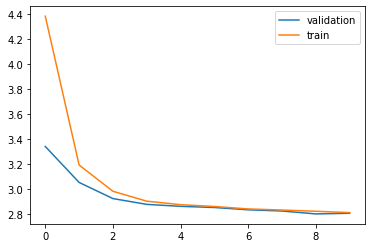

In [265]:
draw_losses(loss, val_loss)

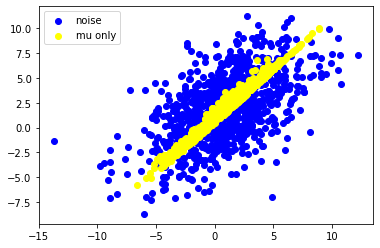

In [266]:
draw_samples(model4, data_2)

**Part B**

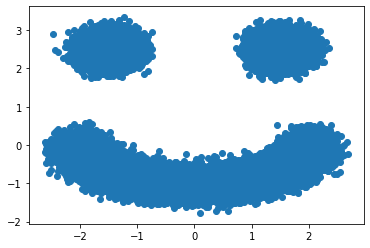

In [267]:
import numpy as np
def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

data_3, labels = sample_data_3()
plt.scatter(data_3[:, 0], data_3[:, 1]);

train_3, test_3 = train_test_split(data_3, train_size=0.8)
train_loader3 = torch.utils.data.DataLoader(train_3, batch_size=batch_size, shuffle=True)
test_loader3 = torch.utils.data.DataLoader(test_3, batch_size=batch_size, shuffle=False) 

After epoch 0 train loss is 2.3557258557669725 valiidation loss is 2.182956337928772
After epoch 1 train loss is 2.143794340423391 valiidation loss is 2.056270694732666
After epoch 2 train loss is 1.92774857599524 valiidation loss is 1.8353174030780792
After epoch 3 train loss is 1.7866225242614746 valiidation loss is 1.7308533251285554
After epoch 4 train loss is 1.6813031510461736 valiidation loss is 1.6468807578086853
After epoch 5 train loss is 1.6037731261192998 valiidation loss is 1.581304657459259
After epoch 6 train loss is 1.5389461864399006 valiidation loss is 1.511964613199234
After epoch 7 train loss is 1.492660204066506 valiidation loss is 1.486493980884552
After epoch 8 train loss is 1.4750362544120112 valiidation loss is 1.4743286967277527
After epoch 9 train loss is 1.4571477808529818 valiidation loss is 1.463468313217163



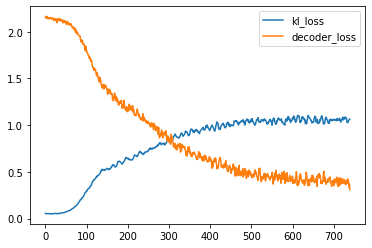

In [268]:
num_epochs = 10
encoder = Encoder(2, 4)
decoder = Decoder(2, 4)
model5 = VAE(encoder, decoder)
optim = torch.optim.Adam(model5.parameters())
loss, val_loss = train(model5, optim, train_loader3, test_loader3, num_epochs)

torch.Size([1000, 2]) torch.Size([1000, 2])


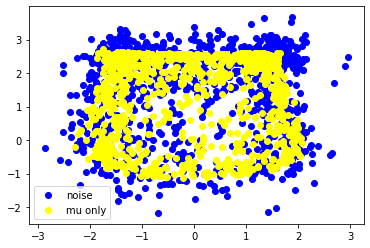

In [269]:
draw_samples(model5)

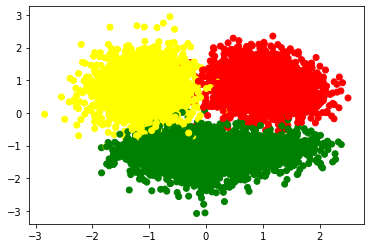

In [270]:
def sample_from_latent(model, n=7000):
    latent, _, _ = model.to_latent(torch.from_numpy(data_3[:n]))
    latent = latent.detach().numpy()
    plt.scatter(latent[:, 0], latent[:, 1], c=np.array(['red', 'yellow', 'green'])[labels[:n]])

sample_from_latent(model5)  

VAE2

After epoch 0 train loss is 2.4542552700525597 valiidation loss is 2.2007280588150024
After epoch 1 train loss is 2.186829029759274 valiidation loss is 2.175649905204773
After epoch 2 train loss is 2.171742224995094 valiidation loss is 2.167787158489227
After epoch 3 train loss is 2.164306879043579 valiidation loss is 2.1566402077674867
After epoch 4 train loss is 2.125877507125275 valiidation loss is 2.0534282088279725
After epoch 5 train loss is 1.8986822517612312 valiidation loss is 1.7667273223400115
After epoch 6 train loss is 1.7088827875596058 valiidation loss is 1.6536435186862946
After epoch 7 train loss is 1.623046550569655 valiidation loss is 1.6140413343906403
After epoch 8 train loss is 1.578185421002062 valiidation loss is 1.563408762216568
After epoch 9 train loss is 1.5549031360239922 valiidation loss is 1.5455862760543824



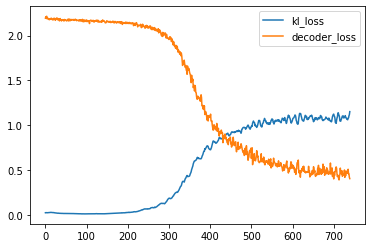

In [271]:
num_epochs = 10
encoder = Encoder(2, 3)
decoder = Decoder(2, 3)
model6 = VAE2(encoder, decoder)
optim = torch.optim.Adam(model6.parameters())
loss, val_loss = train(model6, optim, train_loader3, test_loader3, num_epochs)

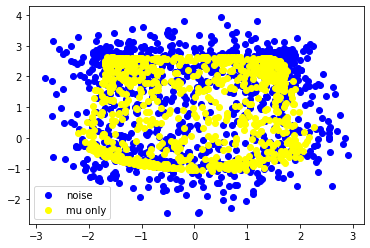

In [272]:
draw_samples(model6)

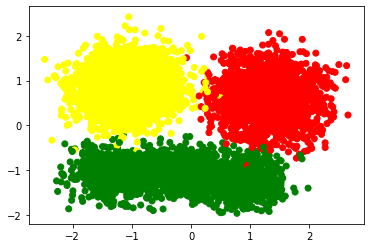

In [273]:
sample_from_latent(model6)  

In [0]:
def p(x, mu=torch.tensor([0.]), sigma=torch.tensor([1.])):
    prob = torch.exp(-0.5 * (x - mu) ** 2 / sigma) / torch.sqrt(2 * np.pi * sigma)
    return prob.prod(dim=1)

def get_iwae(model, x):
    n = x.shape[0]
    z, mu_z, sigma_z = model.to_latent(x)
    
    decoded = model.decoder(z)
    mu_xz, sigma_xz = torch.chunk(decoded, 2, dim=1)

    res = p(x, mu_xz, sigma_xz.exp()) * p(z) / p(z, mu_z, sigma_z.exp())
    return res.mean().log()

In [275]:
iwae100 = get_iwae(model5, torch.tensor(data_3[:100])).item()
iwae1 = get_iwae(model5, torch.tensor(data_3[:1])).item()

print(f"IWAE for 100 {iwae100}")
print(f'IWAE for 1 {iwae1}')

IWAE for 100 -1.902762303518776
IWAE for 1 -2.6443417266646203
